# *Final Project*: Analysis 1

### 1. [Setup](#setup)

### 2. [Incidence by race group over time](#race-incidence)

### 3. [Distribution of metrics by race](#distr-by-race)

***
<a id="setup"></a>
## 1. Setup

In [272]:
import numpy as np
import pandas as pd
import os
import us
from matplotlib import pyplot as plt
from collections import Counter
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind

In [2]:
color_palette = {0:"#f8f8ff", 1:"#ffe4e1", 2:"#ffa07a", 3:"#e9967a", 4:"#fa8072", 5:"#cd5c5c", 6:"#b22222", 7:"#8b0000"}

In [4]:
# project data directory
data_dir = '/Users/shandu/Documents/2019_Fall/statistics/final-project/data/'

data_source = data_dir+'/raw_data_pickles/'
all_data_files = [x for x in os.listdir(data_source) if x != '.DS_Store']

In [5]:
len(all_data_files)

901

In [178]:
num_records = 840666

In [9]:
start_year, end_year = 1975, 2016

In [196]:
def norm(raw_list):
    ''' Normalize a list of values. '''
    return np.array(raw_list)/sum(raw_list)

<a id="race-incidence"></a>
## 2. Incidence by race group over time

This is tricky because of changes in population over time, so can we actually look at all people diagnosed up to a certain year and then normalize by population in that year? Or do we have to only look at diagnoses in a specific year?

In [12]:
### Combine SEER race groups into census race groups ###
# 1=white, 2=black, 3=n_american, 4=asian, 5=pacific

census_race_mapping = {1:1, 2:2, 3:3, 97:5}

asian = [i for i in range(4,9)] + [x for x in range(10,18)] + [x for x in range(20,23)] + \
[x for x in range(25,29)] + [x for x in range(30,33)] + [96]
for i in asian:
    census_race_mapping[i] = 4

In [99]:
years = [str(y) for y in np.arange(start_year, end_year+1)]
race_groups = np.arange(1, 6)

total_year_counts = {year:0 for year in years}

year_race_counts = {year:{race_grp: 0 for race_grp in race_groups} for year in years}

# for each year there is a dictionary entry like this:
# 1975: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, which captures the counts of breast cancer diagoses in each race group

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
        
    #pull out all entries from each year for all years
    for year in years:
        year_df = df[df.YEAR_DX == year]
        total_year_counts[year] += year_df.shape[0]
            
        #remove race groups unknown/other
        year_df = year_df[year_df.RACE1V != '98']
        year_df = year_df[year_df.RACE1V != '99']
        
        #for all entries corresponding to this year, map race codes to census race codes
        race_codes = list(year_df.RACE1V)
        census_race_codes = [census_race_mapping[int(r_i)] for r_i in race_codes]
                
        Counter.update(year_race_counts[year], Counter(census_race_codes))
        
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [119]:
plot_years = ['1980', '1990', '2000', '2010']

In [209]:
white_counts = np.array([year_race_counts[year][1] for year in plot_years])
black_counts = np.array([year_race_counts[year][2] for year in plot_years])
n_american_counts = np.array([year_race_counts[year][3] for year in plot_years])
asian_counts = np.array([year_race_counts[year][4] for year in plot_years])
pacific_counts = np.array([year_race_counts[year][5] for year in plot_years])
asian_pacific_counts = asian_counts+pacific_counts

In [114]:
historical_race_stats = pd.read_csv(data_dir+'historical-pop-by-race.csv')
historical_race_stats = historical_race_stats.set_index('Year')
historical_race_stats

,White,Black,Native American,Asian and PI
Year,,,,
1980,188371622,26495025,1420400,3500439
1990,199686070,29986060,1959234,7273662


In [115]:
# consolidate population by race statistics

all_race_stats = pd.DataFrame(historical_race_stats)
all_race_stats.loc[2000, :] = [211460626, 34658190, 2475956, 10242998+398835]
all_race_stats.loc[2010, :] = [223553265, 38929319, 2932248, 14674252+540013]


race_stats_2018 = pd.read_csv(data_dir+'census-race-stats.csv')
race_stats_2018 = race_stats_2018.set_index('race')

pop = 327167434 #US population in 2018 [from the US Census Bureau (link above)]

# determine raw number of people in each race group according to census
raw_nums = [race_stats.loc[r, 'percent_of_pop']*pop for r in race_stats.index]

all_race_stats.loc[2018, :] = [raw_nums[0], raw_nums[1], raw_nums[2], raw_nums[3]+raw_nums[4]]

all_race_stats

,White,Black,Native American,Asian and PI
Year,,,,
1980,1.883716e+08,2.649502e+07,1420400.000,3.500439e+06
1990,1.996861e+08,2.998606e+07,1959234.000,7.273662e+06
2000,2.114606e+08,3.465819e+07,2475956.000,1.064183e+07
2010,2.235533e+08,3.892932e+07,2932248.000,1.521426e+07
2018,2.502831e+08,4.384044e+07,4253176.642,1.995721e+07


In [210]:
race_labels = ['White', 'Black/African-American', 'Native American', 'Asian and Pacific Islander']

In [217]:
counts_1980 = white_counts[0], black_counts[0], n_american_counts[0], asian_pacific_counts[0]
counts_1990 = white_counts[1], black_counts[1], n_american_counts[1], asian_pacific_counts[1]
counts_2000 = white_counts[2], black_counts[2], n_american_counts[2], asian_pacific_counts[2]
counts_2010 = white_counts[3], black_counts[3], n_american_counts[3], asian_pacific_counts[3]

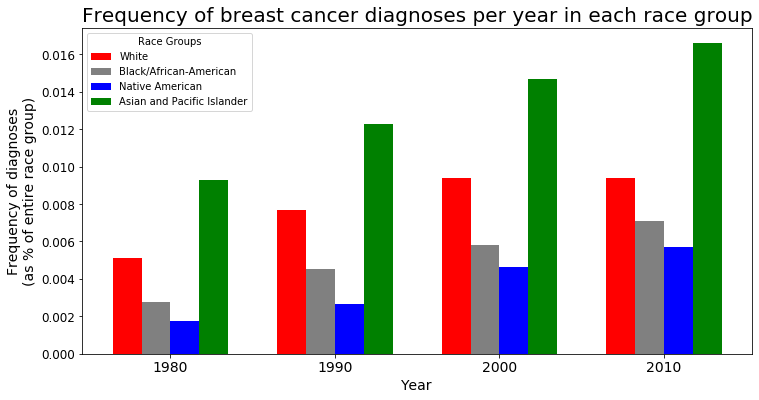

In [250]:
# create stacked bar graph to clearly display proportions

fig, ax = plt.subplots(figsize=(12,6))

x_vals = np.arange(4)
width=0.35

ax.bar(x_vals-3*width/4, white_counts*100/all_race_stats['White'][:4], width/2, color='red')
ax.bar(x_vals-width/4, black_counts*100/all_race_stats['Black'][:4], width/2, color='grey')
ax.bar(x_vals+width/4, n_american_counts*100/all_race_stats['Native American'][:4], width/2, color='blue')
ax.bar(x_vals+3*width/4, asian_pacific_counts*100/all_race_stats['Asian and PI'][:4], width/2, color='green')

ax.set_title('Frequency of breast cancer diagnoses per year in each race group', fontsize=20)
ax.set_ylabel('Frequency of diagnoses\n(as % of entire race group)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
plt.xticks(ticks=np.arange(4), labels=plot_years, fontsize=14)
plt.yticks(fontsize=12)

colors = {0: 'red', 1: 'grey', 2: 'blue', 3: 'green'}
legend_boxes = []
for col_i in range(0, 4):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)
ax.legend(legend_boxes, race_labels, title="Race Groups", \
              loc="upper left")

plt.savefig("barplot-diagnoses-per-year-race.jpeg")

plt.show()

In [121]:
white_counts = (white_counts/all_race_stats['White'][:4])*100.0
black_counts = (black_counts/all_race_stats['Black'][:4])*100.0
n_american_counts = (n_american_counts/all_race_stats['Native American'][:4])*100.0
asian_pacific_counts = (asian_counts/all_race_stats['Asian and PI'][:4])*100.0

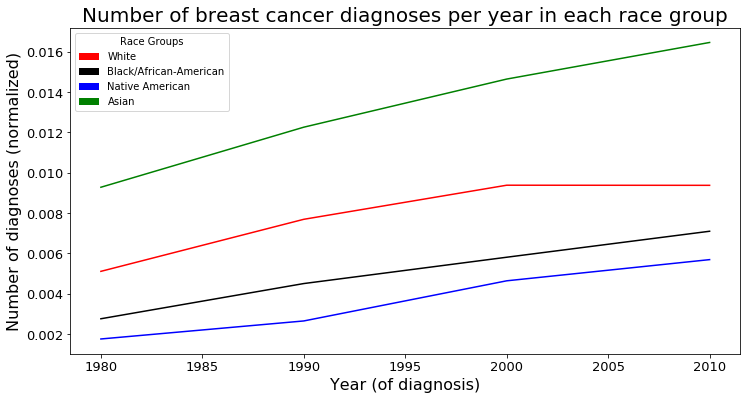

In [192]:
# create line plot

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(white_counts, color='red')
ax.plot(black_counts, color='k')
ax.plot(n_american_counts, color='blue')
ax.plot(asian_pacific_counts, color='green')

ax.set_title('Number of breast cancer diagnoses per year in each race group', fontsize=20)
ax.set_ylabel('Number of diagnoses (normalized)', fontsize=16)
ax.set_xlabel('Year (of diagnosis)', fontsize=16)
#custom_ticks = np.arange(1975, 2016, 5)
#plt.xticks(ticks=np.arange(0,2016-1975,5), labels=custom_ticks)
ax.tick_params(axis='both', which='major', labelsize=13)


colors = {0: 'red', 1: 'k', 2: 'blue', 3: 'green'}
legend_boxes = []
for col_i in range(0, 4):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)
ax.legend(legend_boxes, race_labels, title="Race Groups", \
              loc="upper left")

plt.savefig("lineplot-diagnoses-per-year-race.jpeg")

plt.show()

<a id="distr-by-race"></a>
## 3. Distribution of metrics by race

### Age of diagnosis

In [251]:
race_labels = ['White', 'Black/African-American', 'Native American', 'Asian', 'Pacific Islander']

In [130]:
age_dxs = {i:[] for i in range(1, len(race_labels)+1)}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    #add all years of diagnosis to list for each race group
    for i in df.index:
        race_i = census_race_mapping[int(df.loc[i, 'RACE1V'])]
        age_dxs[race_i].append(int(df.loc[i, 'AGE_DX']))        
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [256]:
for ages_i in age_dxs:
    print(race_labels[ages_i-1], np.median(age_dxs[ages_i]))

White 62.0
Black/African-American 58.0
Native American 56.0
Asian 58.0
Pacific Islander 53.0


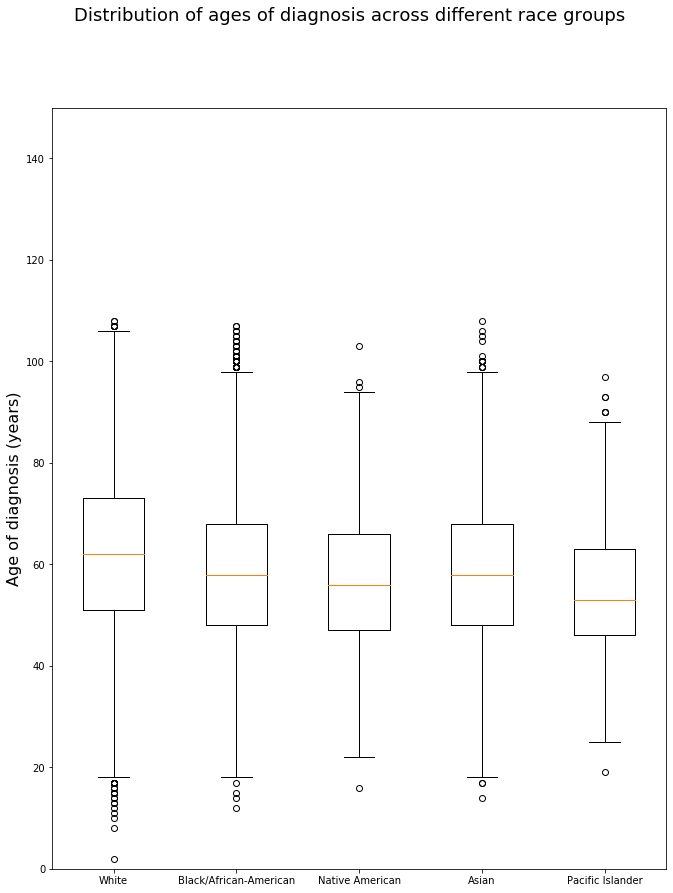

In [271]:
# create box plot

fig, ax = plt.subplots(figsize=(11,14))

ax.boxplot([age_dxs[1], age_dxs[2], age_dxs[3], age_dxs[4], age_dxs[5]])

plt.suptitle('Distribution of ages of diagnosis across different race groups', fontsize=18)
ax.set_ylabel('Age of diagnosis (years)', fontsize=16)

ax.set_xticklabels(race_labels)
ax.set_ylim(0, 150)


plt.savefig("boxplot-age-of-diagnosis.jpeg")

plt.show()

In [273]:
# two-sample hypothesis test for difference of mean age of diagnosis

t_val, p_val = ttest_ind(age_dxs[1], age_dxs[2], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 71.06412613776335
p-value: 0.0


In [354]:
# two-sample hypothesis test for difference of mean age of diagnosis

t_val, p_val = ttest_ind(age_dxs[1], age_dxs[3], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 25.05306243816418
p-value: 4.0034161986034325e-129


In [355]:
# two-sample hypothesis test for difference of mean age of diagnosis

t_val, p_val = ttest_ind(age_dxs[1], age_dxs[4], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 65.81392702030915
p-value: 0.0


In [356]:
# two-sample hypothesis test for difference of mean age of diagnosis

t_val, p_val = ttest_ind(age_dxs[1], age_dxs[5], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 9.494387186586192
p-value: 3.685166724607474e-19


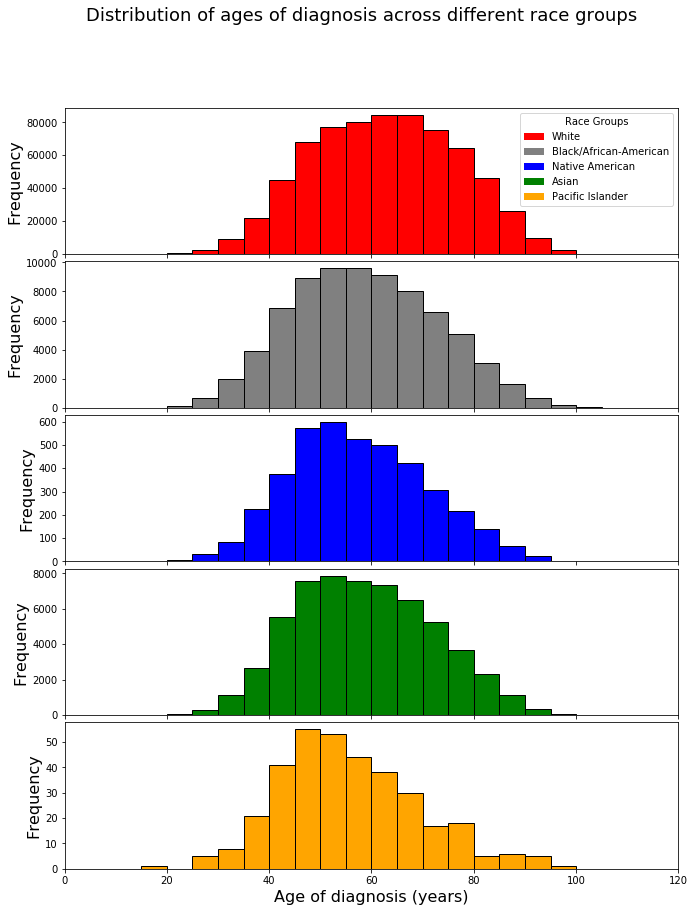

In [262]:
# create histogram

fig, axs = plt.subplots(5, 1, figsize=(11,14), sharex=True, \
                        gridspec_kw={'hspace': 0.05})

legend_labels = race_labels
colors = {0: 'red', 1: 'grey', 2: 'blue', 3: 'green', 4: 'orange'}
legend_boxes = []
for col_i in range(0, 5):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)

axs[0].hist((age_dxs[1]), bins=np.arange(0, 120, 5), color=colors[0], edgecolor="black")
axs[1].hist((age_dxs[2]), bins=np.arange(0, 120, 5), color=colors[1], edgecolor="black")
axs[2].hist((age_dxs[3]), bins=np.arange(0, 120, 5), color=colors[2], edgecolor="black")
axs[3].hist((age_dxs[4]), bins=np.arange(0, 120, 5), color=colors[3], edgecolor="black")
axs[4].hist((age_dxs[5]), bins=np.arange(0, 120, 5), color=colors[4], edgecolor="black")

plt.suptitle('Distribution of ages of diagnosis across different race groups', fontsize=18)
for ax in axs:
    ax.set_ylabel('Frequency', fontsize=16)

axs[4].set_xlabel('Age of diagnosis (years)', fontsize=16)
axs[4].set_xlim(0, 120)
axs[0].legend(legend_boxes, legend_labels, title="Race Groups", \
              loc="upper right")

plt.savefig("histogram-age-of-diagnosis.jpeg")

plt.show()

### Look at change in age of diagnosis across years

In [277]:
age_dxs_by_year_race = {year:{i:[] for i in range(1, len(race_labels)+1)} for year in years}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    for year in years:
        year_df = df[df.YEAR_DX == year]
        
        for i in year_df.index:
            race_i = census_race_mapping[int(df.loc[i, 'RACE1V'])]
            age_dxs_by_year_race[year][race_i].append(int(df.loc[i, 'AGE_DX']))  
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [279]:
median_ages_dx_all_years = []

for year in years:
    age_list = []
    for i in range(1, len(race_labels)+1):
        age_list += age_dxs_by_year_race[year][i]
    median_ages_dx_all_years.append(np.median(age_list))

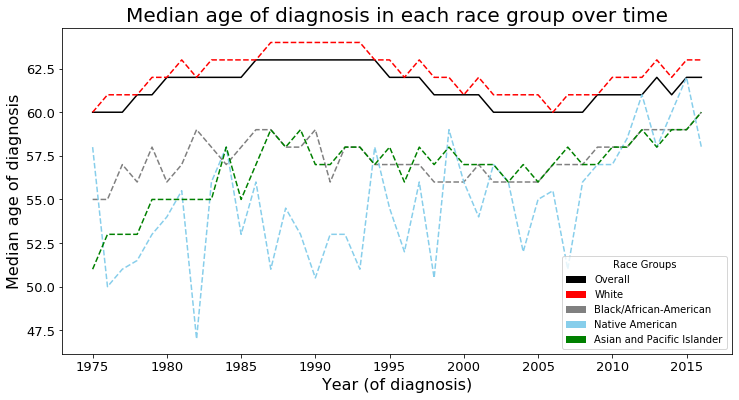

In [357]:
# create line plot

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(median_ages_dx_all_years, color='black')
median_list = []
for y_i in years:
    median_list.append(np.median(age_dxs_by_year_race[y_i][1]))
ax.plot(median_list, color='red', linestyle='--')
median_list = []
for y_i in years:
    median_list.append(np.median(age_dxs_by_year_race[y_i][2]))
ax.plot(median_list, color='grey', linestyle='--')
median_list = []
for y_i in years:
    median_list.append(np.median(age_dxs_by_year_race[y_i][3]))
ax.plot(median_list, color='SkyBlue', linestyle='--')
median_list = []
for y_i in years:
    median_list.append(np.median(age_dxs_by_year_race[y_i][4] + age_dxs_by_year_race[y_i][5]))
ax.plot(median_list, color='green', linestyle='--')

ax.set_title('Median age of diagnosis in each race group over time', fontsize=20)
ax.set_ylabel('Median age of diagnosis', fontsize=16)
ax.set_xlabel('Year (of diagnosis)', fontsize=16)
custom_ticks = np.arange(1975, 2016, 5)
plt.xticks(ticks=np.arange(0,2016-1975,5), labels=custom_ticks)
ax.tick_params(axis='both', which='major', labelsize=13)

legend_labels = ['Overall', 'White', 'Black/African-American', 'Native American', 'Asian and Pacific Islander']
colors = {-1:'black', 0: 'red', 1: 'grey', 2: 'SkyBlue', 3: 'green'}
legend_boxes = []
for col_i in range(-1, 4):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)
ax.legend(legend_boxes, legend_labels, title="Race Groups", \
              loc="lower right")

plt.savefig("lineplot-age-diagnoses-per-year-race.jpeg")

plt.show()

### Survival time

Did they die *because of* breast cancer?

In [170]:
race_labels = ['White', 'Black/African-American', 'Native American', 'Asian', 'Pacific Islander']

surv_times = {i:[] for i in range(1, len(race_labels)+1)}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    #control for patients who died before the follow-up cut-off date
    df = df[df.STAT_REC == '0']
    
    #control for survival time flag
    df_surv_data = df.loc[df['SRV_TIME_MON_FLAG'].isin(['0','1'])]
    
    #add all survival times to list for each race (convert to years)
    for i in df_surv_data.index:
        race_i = census_race_mapping[int(df_surv_data.loc[i, 'RACE1V'])]
        surv_times[race_i].append(float(df_surv_data.loc[i, 'SRV_TIME_MON'])/12.0)        
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [274]:
# two-sample hypothesis test for difference of mean survival time

t_val, p_val = ttest_ind(surv_times[1], surv_times[2], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 46.05897838507785
p-value: 0.0


In [359]:
# two-sample hypothesis test for difference of mean survival time

t_val, p_val = ttest_ind(surv_times[1], surv_times[3], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 11.03198675950175
p-value: 6.807465772832116e-27


In [360]:
# two-sample hypothesis test for difference of mean survival time

t_val, p_val = ttest_ind(surv_times[1], surv_times[4], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 0.7603743796401177
p-value: 0.447041262330406


In [361]:
# two-sample hypothesis test for difference of mean survival time

t_val, p_val = ttest_ind(surv_times[1], surv_times[5], \
                         equal_var=False)

print("Test statistic: " + str(t_val))
print("p-value: " + str(p_val))

Test statistic: 2.523249284726097
p-value: 0.01632039711188594


In [171]:
print('num_patients\tmax')
for l in surv_times:
    print(str(len(surv_times[l])) + '\t' + str(max(surv_times[l])))

num_patients	max
229272	41.833333333333336
32637	41.666666666666664
1071	40.666666666666664
15079	41.166666666666664
36	28.916666666666668


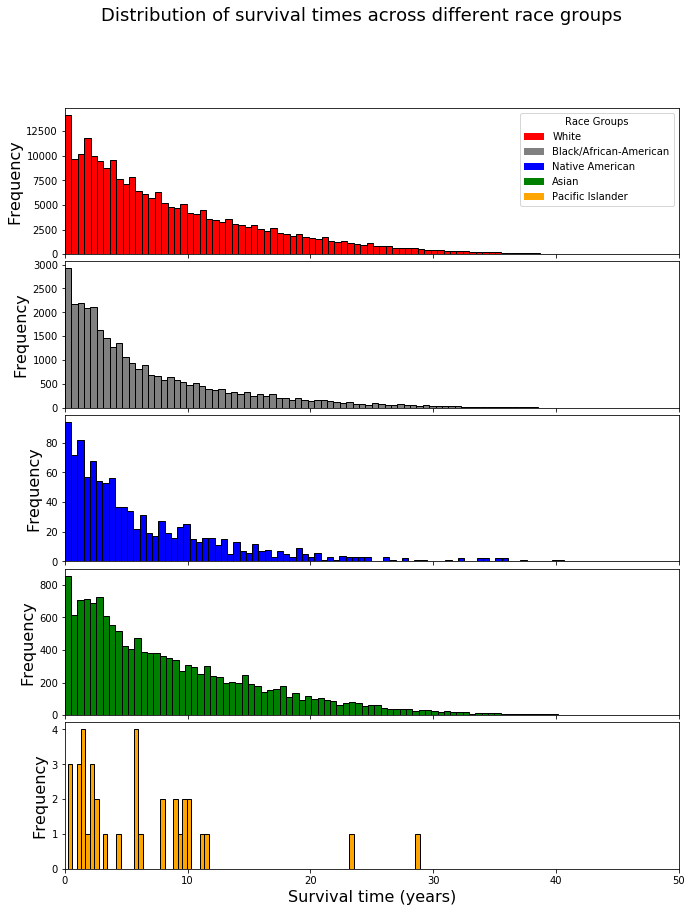

In [172]:
# create histogram

fig, axs = plt.subplots(5, 1, figsize=(11,14), sharex=True, \
                        gridspec_kw={'hspace': 0.05})

legend_labels = race_labels
colors = {0: 'red', 1: 'grey', 2: 'blue', 3: 'green', 4: 'orange'}
legend_boxes = []
for col_i in range(0, 5):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)

axs[0].hist(surv_times[1], bins=80, color=colors[0], edgecolor="black")
axs[1].hist(surv_times[2], bins=80, color=colors[1], edgecolor="black")
axs[2].hist(surv_times[3], bins=80, color=colors[2], edgecolor="black")
axs[3].hist(surv_times[4], bins=80, color=colors[3], edgecolor="black")
axs[4].hist(surv_times[5], bins=80, color=colors[4], edgecolor="black")

plt.suptitle('Distribution of survival times across different race groups', fontsize=18)
for ax in axs:
    ax.set_ylabel('Frequency', fontsize=16)

axs[4].set_xlabel('Survival time (years)', fontsize=16)
axs[4].set_xlim(0, 50)
axs[0].legend(legend_boxes, legend_labels, title="Race Groups", \
              loc="upper right")

plt.savefig("histogram-survival-time.jpeg")

plt.show()

In [326]:
# determine percentage of patients who lived more than 5 years
# but were they older/younger; like maybe also look at percentage of patients under 50 who died within 5 years?

race_percentages = []
for i in surv_times:
    race_percentages.append((sum(np.array(surv_times[i]) > 5)/len(surv_times[i]))*100)

In [327]:
race_percentages

[58.12528350605395,
 45.03477648068144,
 43.04388422035481,
 58.054247629153124,
 50.0]

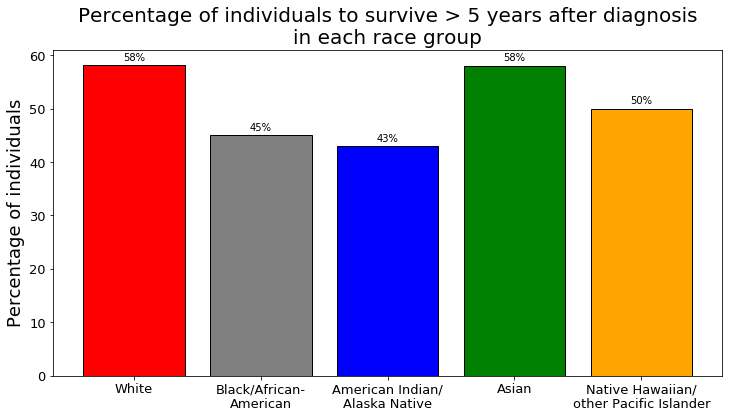

In [345]:
### Create bar graph ###

fig, ax = plt.subplots(figsize=(12,6))

bars = ax.bar(x=np.arange(5), height=race_percentages, color=['red', 'grey', 'blue', 'green', 'orange'], edgecolor="black")
ax.set_title('Percentage of individuals to survive > 5 years after diagnosis\nin each race group', fontsize=20)
ax.set_ylabel('Percentage of individuals', fontsize=18)
plt.xticks(ticks=np.arange(5), labels=race_groups)
ax.tick_params(axis='both', which='major', labelsize=13)

def autolabel(rects):
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars)

plt.savefig("bargraph-survive-after-5-years-race.jpeg")

plt.show()

In [329]:
race_labels = ['White', 'Black/African-American', 'Native American', 'Asian', 'Pacific Islander']

surv_times_under50 = {i:[] for i in range(1, len(race_labels)+1)}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    df = df[df.AGE_DX.astype(float) < 50]
    
    #control for patients who died before the follow-up cut-off date
    df = df[df.STAT_REC == '0']
    
    #control for survival time flag
    df_surv_data = df.loc[df['SRV_TIME_MON_FLAG'].isin(['0','1'])]
    
    #add all survival times to list for each race (convert to years)
    for i in df_surv_data.index:
        race_i = census_race_mapping[int(df_surv_data.loc[i, 'RACE1V'])]
        surv_times_under50[race_i].append(float(df_surv_data.loc[i, 'SRV_TIME_MON'])/12.0)        
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [330]:
race_under50_percentages = []
for i in surv_times_under50:
    race_under50_percentages.append((sum(np.array(surv_times_under50[i]) > 5)/len(surv_times_under50[i]))*100)

In [331]:
race_under50_percentages

[57.322029147982065,
 42.486514256357566,
 42.474916387959865,
 52.93906810035842,
 41.66666666666667]

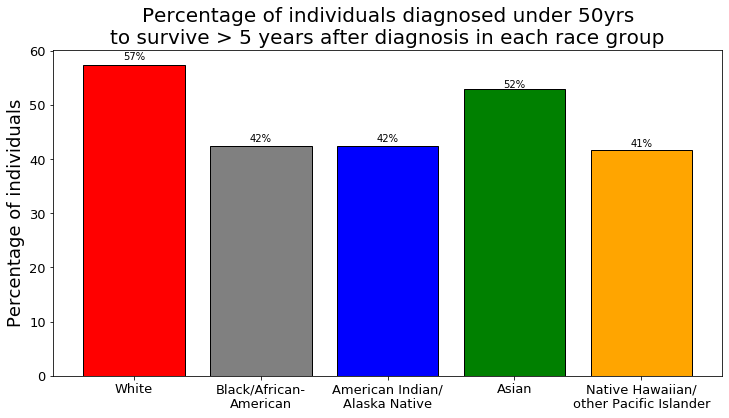

In [371]:
### Create bar graph ###

fig, ax = plt.subplots(figsize=(12,6))

bars = ax.bar(x=np.arange(5), height=race_under50_percentages, color=['red', 'grey', 'blue', 'green', 'orange'], edgecolor="black")
ax.set_title('Percentage of individuals diagnosed under 50yrs\nto survive > 5 years after diagnosis in each race group', fontsize=20)
ax.set_ylabel('Percentage of individuals', fontsize=18)
plt.xticks(ticks=np.arange(5), labels=race_groups)
ax.tick_params(axis='both', which='major', labelsize=13)

def autolabel(rects):
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars)

plt.savefig("bargraph-under50-survive-after-5-years-race.jpeg")

plt.show()

In [311]:
alive_vs_dead = pd.DataFrame(columns=['Race', 'Alive', 'Dead']) #alive/dead as of 2016
white = [0, 0]
black = [0, 0]

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    #control for patients who died before the follow-up cut-off date
    df_dead = df[df.STAT_REC == '0']
    df_alive = df[df.STAT_REC == '1']
    
    for i in df_alive.index:
        race_i = census_race_mapping[int(df_alive.loc[i, 'RACE1V'])]
        if race_i == 1:
            white[0] += 1
        elif race_i == 2:
            black[0] += 1
            
    for i in df_dead.index:
        race_i = census_race_mapping[int(df_dead.loc[i, 'RACE1V'])]
        if race_i == 1:
            white[1] += 1
        elif race_i == 2:
            black[1] += 1       
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1
    
alive_vs_dead.loc[0, :] = ['white'] + white
alive_vs_dead.loc[1, :] = ['black'] + black

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [313]:
alive_vs_dead = alive_vs_dead.set_index('Race')
alive_vs_dead

,Alive,Dead
Race,,
white,362092,335364
black,40363,35669


In [362]:
alive_vs_dead.to_csv('alive_vs_dead.csv')

In [318]:
# chi square test
row_totals = [sum(alive_vs_dead.loc['white', :]), sum(alive_vs_dead.loc['black', :])]
col_totals = [sum(alive_vs_dead['Alive']), sum(alive_vs_dead['Dead'])]
total = sum(row_totals)

e1 = (row_totals[0]*col_totals[0])/total
e2 = (row_totals[0]*col_totals[1])/total
e3 = (row_totals[1]*col_totals[0])/total
e4 = (row_totals[1]*col_totals[1])/total

o1, o2 = alive_vs_dead.loc['white', :]
o3, o4 = alive_vs_dead.loc['black', :]

chi_squared = (o1-e1)**2/e1 + (o2-e2)**2/e2 + (o3-e3)**2/e3 + (o4-e4)**2/e4
print('Chi-squared test statistic:', chi_squared)

Chi-squared test statistic: 37.65013052919065


According to [online p-value calculator](https://www.socscistatistics.com/pvalues/chidistribution.aspx), $p << 0.00001$, so there is a statistically significant difference between proportion of black patients who died and white respondents who died before end of study. This is more striking when we also consider the fact that black patients are on average younger than white patients. Therefore, black patients are dying earlier.

### Stage at diagnosis

Effective for 2004-2015 diagnoses.

In [179]:
missing_vals_df = pd.read_csv('col_num_missing_values.csv').set_index('datapoint')
missing_vals_df.loc['DSS1977S', 'missing_count']/num_records

0.6172035029369571

In [184]:
race_labels = ['White', 'Black/African-American', 'Native American', 'Asian', 'Pacific Islander']

stages = {i:{str(j):0 for j in [0,1,2,3,4,5,7,8,9]} for i in range(1, len(race_labels)+1)}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    #remove race groups unknown/other
    df = df[df.RACE1V != '98']
    df = df[df.RACE1V != '99']
    
    #add all stage diagnoses to list for each race
    for i in df.index:
        stage = df.loc[i, 'DSS1977S']
        if type(stage) == str:
            race_i = census_race_mapping[int(df.loc[i, 'RACE1V'])]
            stages[race_i][stage] += 1
       
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

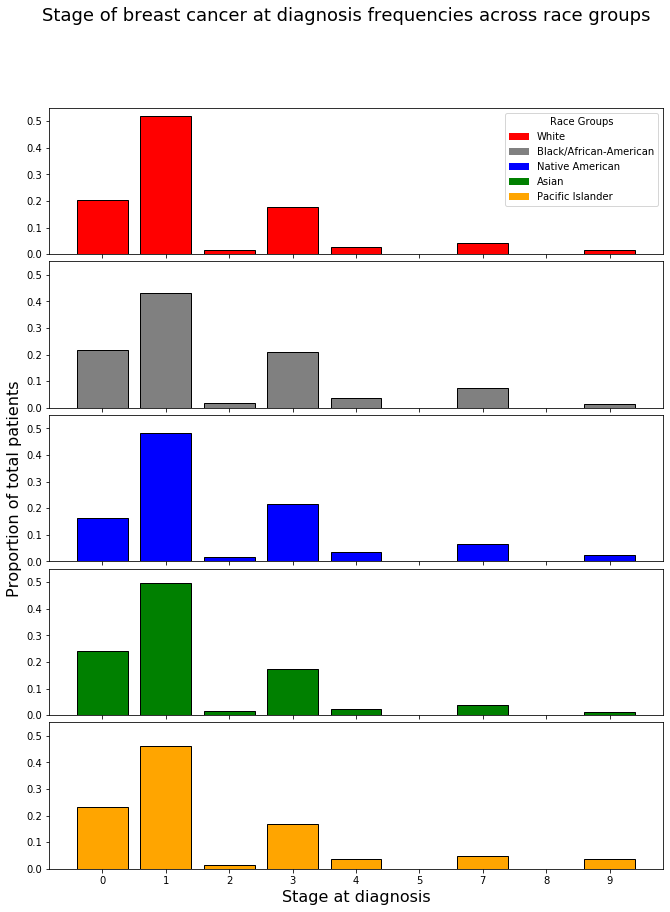

In [206]:
# create histogram

fig, axs = plt.subplots(5, 1, figsize=(11,14), sharex=True, \
                        gridspec_kw={'hspace': 0.05})

legend_labels = race_labels
colors = {0: 'red', 1: 'grey', 2: 'blue', 3: 'green', 4: 'orange'}
legend_boxes = []
for col_i in range(0, 5):
    box = Rectangle((0, 0), 1, 1, fc=colors[col_i])
    legend_boxes.append(box)

axs[0].bar(np.arange(9), norm([stages[1][str(x)] for x in [0,1,2,3,4,5,7,8,9]]), tick_label=[0,1,2,3,4,5,7,8,9], color=colors[0], edgecolor="black")
axs[1].bar(np.arange(9), norm([stages[2][str(x)] for x in [0,1,2,3,4,5,7,8,9]]), tick_label=[0,1,2,3,4,5,7,8,9], color=colors[1], edgecolor="black")
axs[2].bar(np.arange(9), norm([stages[3][str(x)] for x in [0,1,2,3,4,5,7,8,9]]), tick_label=[0,1,2,3,4,5,7,8,9], color=colors[2], edgecolor="black")
axs[3].bar(np.arange(9), norm([stages[4][str(x)] for x in [0,1,2,3,4,5,7,8,9]]), tick_label=[0,1,2,3,4,5,7,8,9], color=colors[3], edgecolor="black")
axs[4].bar(np.arange(9), norm([stages[5][str(x)] for x in [0,1,2,3,4,5,7,8,9]]), tick_label=[0,1,2,3,4,5,7,8,9], color=colors[4], edgecolor="black")

plt.suptitle('Stage of breast cancer at diagnosis frequencies across race groups', fontsize=18)

axs[2].set_ylabel('Proportion of total patients', fontsize=16)

axs[4].set_xlabel('Stage at diagnosis', fontsize=16)

for ax in axs:
    ax.set_ylim(0, 0.55)
#axs[4].set_xlim(0, 50)
axs[0].legend(legend_boxes, legend_labels, title="Race Groups", \
              loc="upper right")

plt.savefig("histogram-stage-at-diagnosis.jpeg")

plt.show()

In [368]:
white_early_stage = stages[1]['0'] + stages[1]['1']
white_late_stage = stages[1]['2'] + stages[1]['3'] + stages[1]['4'] + stages[1]['5'] + stages[1]['7']

black_early_stage = stages[2]['0'] + stages[2]['1']
black_late_stage = stages[2]['2'] + stages[2]['3'] + stages[2]['4'] + stages[2]['5'] + stages[2]['7']

cancer_stage = pd.DataFrame(columns=['race', 'early stage', 'late stage'])
cancer_stage.loc[0, :] = ['white', white_early_stage, white_late_stage]
cancer_stage.loc[1, :] = ['black', black_early_stage, black_late_stage]
cancer_stage = cancer_stage.set_index('race')
cancer_stage

,early stage,late stage
race,,
white,182856,66802
black,22078,11576


In [369]:
# chi square test
row_totals = [sum(cancer_stage.loc['white', :]), sum(cancer_stage.loc['black', :])]
col_totals = [sum(cancer_stage['early stage']), sum(cancer_stage['late stage'])]
total = sum(row_totals)

e1 = (row_totals[0]*col_totals[0])/total
e2 = (row_totals[0]*col_totals[1])/total
e3 = (row_totals[1]*col_totals[0])/total
e4 = (row_totals[1]*col_totals[1])/total

o1, o2 = cancer_stage.loc['white', :]
o3, o4 = cancer_stage.loc['black', :]

chi_squared = (o1-e1)**2/e1 + (o2-e2)**2/e2 + (o3-e3)**2/e3 + (o4-e4)**2/e4
print('Chi-squared test statistic:', chi_squared)

Chi-squared test statistic: 864.9501572093166


In [370]:
o2/row_totals[0], o4/row_totals[1]

(0.26757404128848267, 0.3439709989897189)